# **California housing:** *a Machine Learning implementation*

Markdown-text i denna notebook täcks fullständigt i skriftliga rapporten. Markdown-cellerna behålles häri ändå.

## Setup

In [ ]:
# Importera bibliotek
# python -m pip install numpy pandas matplotlib seaborn scikit-learn ipykernel
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    average_precision_score,
    classification_report,
    roc_auc_score,
    roc_curve
)


# Reproducerbarhet
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

# Ladda in housing.csv
import sys, os 
sys.path.append(os.path.abspath(".."))
df = pd.read_csv("./data/housing.csv")
df.tail(3)

## Dataöversikt

In [ ]:
print(f"Här är orginella features i bostadsdata:\n {list(df.columns)}\n")
print(f"Bostadsdata har storleken {df.shape}.")
print("\nKolumnerna har datatyperna:")
display(df.dtypes)

print("Beskrivande statistik på numerisk data:")
df.describe().round(2)

# Notera att huspriserna senare används för att flagga högpris-områden och sen utesluts.


print("Vad för texter finns i kolumnen närhet till hav:")
display(pd.DataFrame(df["ocean_proximity"].value_counts()))

missing_vals = df.isna().sum()
print("Här är kolumner med antalet tomma rader:")
missing_vals[missing_vals > 0]

# Notera att om det saknas värden kan imputering behövas. Detta görs ofta genom att medianvärdet sätts in.

Här är orginella features i bostadsdata:
 ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']

Bostadsdata har storleken (20640, 10).

Kolumnerna har datatyperna:


longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

Beskrivande statistik på numerisk data:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.00,20640.00,20640.00,20640.00,20433.00,20640.00,20640.00,20640.00,20640.00
mean,-119.57,35.63,28.64,2635.76,537.87,1425.48,499.54,3.87,206855.82
std,2.00,2.14,12.59,2181.62,421.39,1132.46,382.33,1.90,115395.62
min,-124.35,32.54,1.00,2.00,1.00,3.00,1.00,0.50,14999.00
25%,-121.80,33.93,18.00,1447.75,296.00,787.00,280.00,2.56,119600.00
50%,-118.49,34.26,29.00,2127.00,435.00,1166.00,409.00,3.53,179700.00
75%,-118.01,37.71,37.00,3148.00,647.00,1725.00,605.00,4.74,264725.00
max,-114.31,41.95,52.00,39320.00,6445.00,35682.00,6082.00,15.00,500001.00


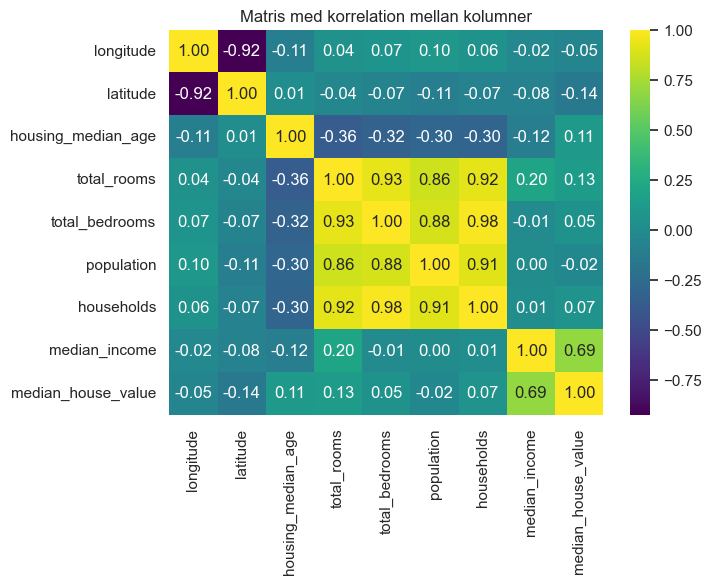

In [ ]:
plt.figure(figsize=(7,5))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="viridis")
plt.title("Matris med korrelation mellan kolumner")
plt.show()


plt.figure(figsize=(8,6))
plt.title("Koordinatplot med bostadsvärderingar")
sns.scatterplot(x=df["longitude"], y=df["latitude"], hue=df["median_house_value"], alpha=0.6, palette="viridis")
plt.show()

I figuren ovan syns korrelation mellan kolumnerna i bostadsdata. Koordinater, antal rum samt befolkning och hushåll, och inkomst samt huspris har som grupperat nära länkade värden. Huspriset ska uteslutas och en kategori för områden som är högprisade eller inte ska istället vara fokus för prediktioner. Orginell data korrelerad såhär framstår rimligt.

En scatterplot med x- och y-koordinater tillsammans med huspriser för färgskala skissar upp bostadsdata för västkusten i USA. Det tycks billigare att bo inåt landet än längsmed kusten.

## Skapa target och Featureanpassning

Först gör vi en *target*-kolumn `high_value` som sätter en etta ifall medianhusvärdet för raden tillhör de översta tjugo procenten, annars en nolla.

Sedan görs och sparas bråktal kolumner för rum per hus, sovrum per hus och befolkning per hus. Dessa ersätter summerande kolumnerna `total_rooms`, `total_bedrooms`, `population`, `households`. 

> Viss förlust av skala kan inträffa medan jämförbarhet träder in. Skulle summerande kolumnerna sparas jämsides med bråktalen uppstår multikolinearitet och därigenom möjligen brus. Empiriskt skulle det gå att göra mätningar med bråktal, bråktal samt summerande, och endast summerande dataset, men för koncishet fortsätter arbetet med bråktal för jämförbarheten framhävs för beslutsfattare.

Närhet till hav kodas med OneHotEncoder då stigande siffror skulle introducera bias.

Till slut tas kolumner som är summerande samt huspriserna bort.

In [ ]:
threshold = df["median_house_value"].quantile(0.8)
df["high_value"] = (df["median_house_value"] >= threshold).astype(int) # från True till 1, False till 0.

print(f"Tröskelvärdet som skiljer högpris från övriga är ${threshold.astype(int)}.\n")


# Bråktal
df["rooms_per_h"] = df["total_rooms"] / df["households"]
df["bedrooms_per_h"] = df["total_bedrooms"] / df["households"]
df["pop_per_h"] = df["population"] / df["households"]

# OneHotEncoding
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

X_cat_ohe = ohe.fit_transform(df[["ocean_proximity"]])
ocean_cols = ohe.get_feature_names_out(["ocean_proximity"])

df_ocean_temp = pd.DataFrame(X_cat_ohe, columns=ocean_cols, index=df.index)
df = pd.concat([df, df_ocean_temp], axis=1)


drop_columns = ["median_house_value", "total_rooms", "total_bedrooms", 
                "population", "households", "ocean_proximity"]
df = df.drop(columns=drop_columns)

print(f"Dataset efter featureanpassning:\n")
display(df.tail(3).round(2).T)

Tröskelvärdet som skiljer högpris från övriga är $290000.

Dataset efter featureanpassning:



,20637,20638,20639
longitude,-121.22,-121.32,-121.24
latitude,39.43,39.43,39.37
housing_median_age,17.00,18.00,16.00
median_income,1.70,1.87,2.39
high_value,0.00,0.00,0.00
rooms_per_h,5.21,5.33,5.25
bedrooms_per_h,1.12,1.17,1.16
pop_per_h,2.33,2.12,2.62
ocean_proximity_<1H OCEAN,0.00,0.00,0.00
ocean_proximity_INLAND,1.00,1.00,1.00


## Train/test split

In [ ]:
X = df.drop("high_value", axis=1) # features
y = df["high_value"] # target

# Stratify=y håller balansen lik i train + test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y)

# Se över storlek på split och behållen balans
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}\n")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}\n")
print(f"Balans i y_train:\n {np.round(y_train.value_counts(normalize=True),2)}\n")
print(f"Balans i y_test:\n{np.round(y_test.value_counts(normalize=True),2)}")

X_train: (16512, 12)
X_test: (4128, 12)

y_train: (16512,)
y_test: (4128,)

Balans i y_train:
 high_value
0    0.8
1    0.2
Name: proportion, dtype: float64

Balans i y_test:
high_value
0    0.8
1    0.2
Name: proportion, dtype: float64


## Preprocessing och Pipeline

Med OneHot-encodad närhet till hav låter vi preprocessing ha stegen: 
* SimpleImputer ersätter blanka fält med medianen (most frequent),
* StandardScaler försäkrar medelvärdet noll och standardavvikelse ett för features.

In [ ]:
preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

print("Preprocessor definierad.\n")

Preprocessor definierad.



## Baseline

Enkel modelltyp som kör preprocessing och sedan DummyClassifier som alltid gissar oftast förekommande värdet för att få något att jämföra senare modeller med.

Förväntan är 80% på accuracy då noll förekommer just så ofta (endast 20% tillfalles en etta motsvarigt högprisområde klassificeringen).

In [ ]:
baseline_model = Pipeline(steps=[
    ("preprocessor", preprocess),
    ("model", DummyClassifier(strategy="most_frequent", random_state=RANDOM_SEED))
])

# Träna baseline-modell på träningsdata och predikera
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_train)

print("Klassificeringsrapport på Baseline:\n")
print(classification_report(y_train, y_pred_baseline, zero_division=0))

Klassificeringsrapport på Baseline:

              precision    recall  f1-score   support

           0       0.80      1.00      0.89     13208
           1       0.00      0.00      0.00      3304

    accuracy                           0.80     16512
   macro avg       0.40      0.50      0.44     16512
weighted avg       0.64      0.80      0.71     16512



## Jämför modeller: *Cross Validation på träningsdata*

Med stratifierad KFold skyfflas femdelad testdata (varav en validering) runt och tas medelvärde på för modellerna i undersökning, inklusive baseline. Resultaten sparas i en dataframe med fallande ordning för måttet F1. Varför F1 över precision eller recall grundar sig i att en balanserad modell lär inte vara för feg för att gissa fel, samtidigt som falsklarm lär bli begränsade, respektivt. Det är önskvärt att gissa rätt ofta *och* snappa upp de flesta.

In [ ]:
models = {
    "Baseline": DummyClassifier(strategy="most_frequent", random_state=RANDOM_SEED),
    "Logistic Regression": LogisticRegression(max_iter=5000, random_state=RANDOM_SEED),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_SEED),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=RANDOM_SEED)
}

compare_models = [] # lagra resultat

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocess), # innehöll imputer och standardscaler
        ("model", model)
    ])
    
    cv_scores = cross_validate(
        pipeline, 
        X_train, 
        y_train, 
        cv=cv, 
        scoring=["accuracy", "precision", "recall", "f1"],
        n_jobs=-1
    )
    
    # Lagra medelvärde per fold
    compare_models.append({
        "Model": name,
        "Accuracy": cv_scores["test_accuracy"].mean(),
        "Precision": cv_scores["test_precision"].mean(),
        "Recall": cv_scores["test_recall"].mean(),
        "F1": cv_scores["test_f1"].mean()
    })

cv_df = pd.DataFrame(compare_models).sort_values(by="F1", ascending=False)

print("Cross validation av 4 modeller:")
display(np.round(cv_df,4))

Cross validation av 4 modeller:


,Model,Accuracy,Precision,Recall,F1
3,Random Forest,0.9277,0.8732,0.7473,0.8052
2,Decision Tree,0.8864,0.7163,0.7161,0.7161
1,Logistic Regression,0.8860,0.8004,0.5735,0.6681
0,Baseline,0.7999,0.0000,0.0000,0.0000


## Välj modell och optimera hyperparametrar

Vi låter python välja modellen med störst F1 score, och fortsätter med GridSearchCV med syftet att få fram hyperparameter värden som gör modellen optimerad. På så vis bör en bättre F1 score kunna erhållas.

In [ ]:
best_model_name = cv_df.iloc[0]["Model"]
print("Vald modell: ", models[best_model_name])

top_model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocess),
    ("model", models[best_model_name])
])

# Hyperparameter Grid
param_grid = {
    "model__n_estimators": [250, 300, 350],
    "model__max_depth": [15, 20, 27],
    "model__min_samples_split": [2,3]
}

# GridSearchCV konfigurering
grid_search = GridSearchCV(
    estimator=top_model_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="f1",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\nOptimerade hyperparametrar:")
print(grid_search.best_params_)
print(f"Högsta F1 enl. CV: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_ # lagra

Vald modell:  RandomForestClassifier(n_estimators=300, random_state=42)

Optimerade hyperparametrar:
{'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 300}
Högsta F1 enl. CV: 0.8070


## Utvärdera vald modell på testdata

Vald modell körd optimerat på testdata -- resultat:


,Metric,Resultat
0,Accuracy,0.924
1,Precision,0.864
2,Recall,0.734
3,F1,0.794
4,ROC-AUC,0.964


Area under ROC:  0.964


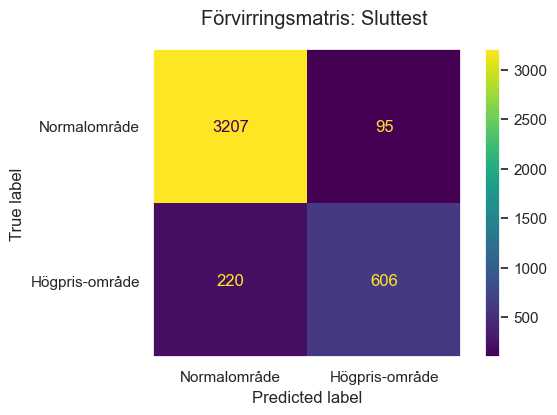

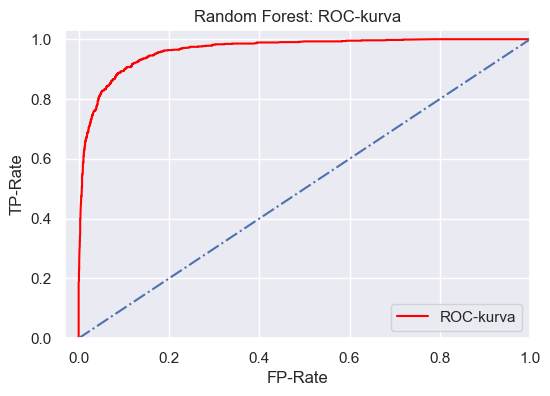

In [ ]:
y_pred_test = best_model.predict(X_test)

y_proba = best_model.predict_proba(X_test)[:, 1] # för roc-auc

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, zero_division=0)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test, zero_division=0)
auc = roc_auc_score(y_test, y_proba)


print("Vald modell körd optimerat på testdata -- resultat:")

summary_stats = pd.DataFrame({
    'Metric': ["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"],
    "Resultat": [accuracy, precision, recall, f1, auc]
})
display(summary_stats.round(3))


# Förvirringsmatris och ROC-kurva
fig, ax = plt.subplots(figsize=(6,4))
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normalområde", "Högpris-område"])
disp.plot(ax=ax, cmap="viridis")
plt.suptitle("Förvirringsmatris: Sluttest")
plt.grid(False)

fpr, tpr, threshold = roc_curve(y_test, y_proba)
print("Area under ROC: ", np.round(auc,3))

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='red', label='ROC-kurva')
plt.plot([0,1],[0,1], linestyle='-.')
plt.xlim([-0.03,1.0])
plt.ylim([0.0,1.03])
plt.xlabel('FP-Rate')
plt.ylabel('TP-Rate')
plt.title('Random Forest: ROC-kurva')
plt.legend()
plt.show()

## Oövervakad inlärning

## Fördjupning